In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/"

In [3]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Pneumonia/chest_xray/chest_xray

/content/gdrive/MyDrive/Colab Notebooks/Pneumonia/chest_xray/chest_xray


In [4]:
# !kaggle datasets download paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip

In [5]:
import pathlib
import numpy as np
import pandas as pd
import glob, os, cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, Dropout, Conv2D, Activation, MaxPool2D, SeparableConv2D, BatchNormalization, MaxPooling2D
AUTOTUNE = tf.data.AUTOTUNE 

In [7]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Pneumonia/chest_xray/chest_xray/'
train_path = data_dir + 'train'
test_path = data_dir + 'test'
val_path = data_dir + 'val'

In [8]:
img_height = 224
img_width = 224
batch_size = 32
img_fold = ['train', 'test', 'val']
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
for _ in img_fold:
  print("Directories in {}_path : {}".format(_, os.listdir(_)))

Directories in train_path : ['NORMAL', 'PNEUMONIA']
Directories in test_path : ['NORMAL', 'PNEUMONIA']
Directories in val_path : ['NORMAL', 'PNEUMONIA']


In [10]:
for _ in img_fold:
  normal = len(os.listdir(data_dir + _ + '/NORMAL'))
  pneumonia = len(os.listdir(data_dir + _ + '/PNEUMONIA'))
  print("Number of images in {} set : {}" .format(_, normal+pneumonia))
  print("{} --- Normal images : {} Pneumonia images : {}\n" .format(_, normal, pneumonia))

Number of images in train set : 5216
train --- Normal images : 1341 Pneumonia images : 3875

Number of images in test set : 624
test --- Normal images : 234 Pneumonia images : 390

Number of images in val set : 16
val --- Normal images : 8 Pneumonia images : 8



In [11]:
train_images = tf.io.gfile.glob(str(train_path)+'/*/*')
train_images.extend(tf.io.gfile.glob(str(val_path) + '/*/*'))

train_image_count = len(train_images)
print("Total training images : ", train_image_count)

Total training images :  5232


In [12]:
normal_images = os.listdir(train_path + '/NORMAL')
pneumonia_images = os.listdir(train_path + '/PNEUMONIA')

Normal Images : 


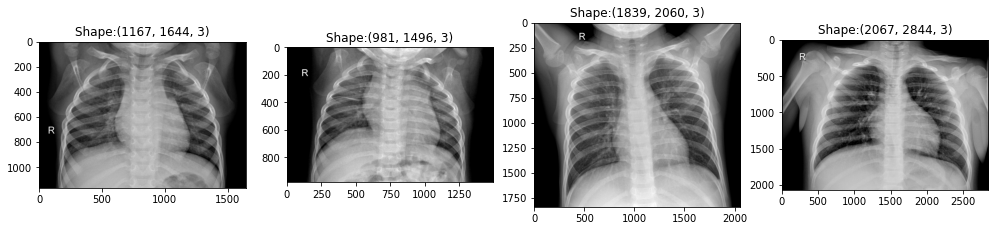

In [13]:
print("Normal Images : ")
i = 1
plt.figure(figsize=(17, 15))
for j in normal_images[:4]:
  plt.subplot(1, 4, i)
  image = cv2.imread(train_path + '/NORMAL/' + j)
  plt.imshow(image)
  plt.title("Shape:{}".format(image.shape))
  i = i+1

Pneumonia Images : 


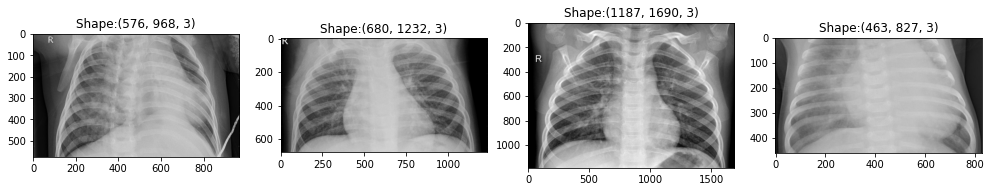

In [14]:
print("Pneumonia Images : ")
i = 1
plt.figure(figsize=(17, 15))
for j in pneumonia_images[:4]:
  plt.subplot(1, 4, i)
  image = cv2.imread(train_path + '/PNEUMONIA/' + j)
  plt.imshow(image)
  plt.title("Shape:{}".format(image.shape))
  i = i+1

In [15]:
train_images_ds = tf.data.Dataset.list_files(train_images, shuffle = False)
train_images_ds = train_images_ds.shuffle(train_image_count, reshuffle_each_iteration = False)

In [16]:
val_size = int(train_image_count * 0.20)
val_ds = train_images_ds.take(val_size)
train_ds = train_images_ds.skip(val_size)

In [17]:
train_image_count = tf.data.experimental.cardinality(train_ds).numpy()
val_image_count = tf.data.experimental.cardinality(val_ds).numpy()
print("Number of training images : ", train_image_count)
print("Number of validation images : ", val_image_count)

Number of training images :  4186
Number of validation images :  1046


In [18]:
test_images = tf.io.gfile.glob(str(test_path)+'/*/*')
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_image_count = len(test_ds)

print("Number of test images : ", test_image_count)

Number of test images :  624


In [19]:
class_names = np.unique([ tf.strings.split(i, '/')[-2].numpy().decode('utf-8') for i in train_images])
class_names

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [20]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  return img

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [21]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [22]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [23]:
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


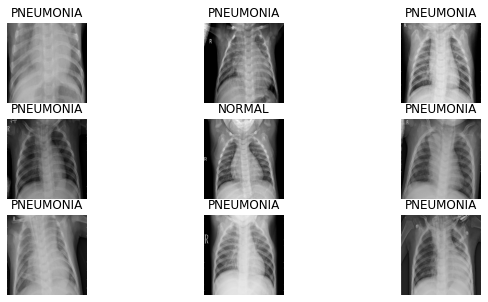

In [24]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 5))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  print(label)
  plt.title(class_names[label])
  plt.axis("off")

In [25]:
IMG_SHAPE = (img_height, img_width, 3)

In [26]:
train_steps = train_image_count // batch_size
val_steps= val_image_count // batch_size

In [27]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),                  
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.45),                      
                                         tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15)),
                                         ])

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
def make_model():
  base_model = MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights = 'imagenet')
  base_model.trainable = False
  model = Sequential([data_augmentation,
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(32, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model_1 = make_model()

In [ ]:
history = model_1.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 5, 
    validation_data=val_ds,
    validation_steps = val_steps
)

Epoch 1/5
130/130 [==============================] - 580s 4s/step - loss: 0.3429 - accuracy: 0.8584 - val_loss: 0.3178 - val_accuracy: 0.8799
Epoch 2/5
130/130 [==============================] - 170s 1s/step - loss: 0.1981 - accuracy: 0.9327 - val_loss: 0.7033 - val_accuracy: 0.7559
Epoch 3/5
130/130 [==============================] - 170s 1s/step - loss: 0.1661 - accuracy: 0.9361 - val_loss: 0.5245 - val_accuracy: 0.8057
Epoch 4/5
130/130 [==============================] - 170s 1s/step - loss: 0.1448 - accuracy: 0.9445 - val_loss: 0.4002 - val_accuracy: 0.8340
Epoch 5/5
130/130 [==============================] - 170s 1s/step - loss: 0.1429 - accuracy: 0.9476 - val_loss: 0.2960 - val_accuracy: 0.8701


In [ ]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,299,137
Trainable params: 41,089
Non-trainable params: 2,258,048
_______________________________________

In [ ]:
model_1.evaluate(test_ds)

20/20 [==============================] - 63s 3s/step - loss: 0.3069 - accuracy: 0.8622


[0.3069450855255127, 0.8621794581413269]

In [ ]:
model_1.save('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/mobilenet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
def make_model():
  base_model = Xception(input_shape = IMG_SHAPE, include_top=False, weights = 'imagenet')
  base_model.trainable = False
  model = Sequential([data_augmentation,
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(32, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model_2 = make_model()
history = model_2.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 5,
    validation_data=val_ds,
    validation_steps = val_steps
)

Epoch 1/5
130/130 [==============================] - 986s 7s/step - loss: 0.3302 - accuracy: 0.8654 - val_loss: 0.5076 - val_accuracy: 0.7432
Epoch 2/5
130/130 [==============================] - 917s 7s/step - loss: 0.2028 - accuracy: 0.9243 - val_loss: 0.3838 - val_accuracy: 0.8428
Epoch 3/5
130/130 [==============================] - 916s 7s/step - loss: 0.1930 - accuracy: 0.9298 - val_loss: 0.8892 - val_accuracy: 0.6660
Epoch 4/5
130/130 [==============================] - 917s 7s/step - loss: 0.1728 - accuracy: 0.9346 - val_loss: 0.1568 - val_accuracy: 0.9326
Epoch 5/5
130/130 [==============================] - 916s 7s/step - loss: 0.1583 - accuracy: 0.9380 - val_loss: 0.1940 - val_accuracy: 0.9238


In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 20,927,209
Trainable params: 65,665
Non-trainable params: 20,861,544
_____________________________________

In [ ]:
model_2.evaluate(test_ds)

20/20 [==============================] - 114s 6s/step - loss: 0.3408 - accuracy: 0.8686


[0.3407503664493561, 0.8685897588729858]

In [ ]:
model_2.save('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/xception.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
def make_model():
  base_model = InceptionV3(input_shape = IMG_SHAPE, include_top=False, weights = 'imagenet')
  base_model.trainable = False
  model = Sequential([data_augmentation,
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(32, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model_3 = make_model()
history = model_3.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 5, 
    validation_data=val_ds,
    validation_steps = val_steps
)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/5
130/130 [==============================] - 555s 4s/step - loss: 0.3637 - accuracy: 0.8413 - val_loss: 0.2951 - val_accuracy: 0.8926
Epoch 2/5
130/130 [==============================] - 549s 4s/step - loss: 0.2381 - accuracy: 0.9099 - val_loss: 0.2396 - val_accuracy: 0.8984
Epoch 3/5
130/130 [==============================] - 548s 4s/step - loss: 0.1996 - accuracy: 0.9245 - val_loss: 0.3893 - val_accuracy: 0.8516
Epoch 4/5
130/130 [==============================] - 549s 4s/step - loss: 0.1869 - accuracy: 0.9248 - val_loss: 0.3035 - val_accuracy: 0.8779
Epoch 5/5
130/130 [==============================] - 549s 4s/step - loss: 0.1779 - accuracy: 0.9303 - val_loss: 0.1811 - val_accuracy: 0.9297


In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                65568     
_________________________________________________________________
batch_normalization_99 (Batc (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 21,868,513
Trainable params: 65,665
Non-trainable params: 21,802,848
_____________________________________

In [ ]:
model_3.evaluate(test_ds)

20/20 [==============================] - 70s 3s/step - loss: 0.5395 - accuracy: 0.7853


[0.539493978023529, 0.7852563858032227]

In [ ]:
model_3.save('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/inception.h5')

In [82]:
model_1 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/mobilenet.h5')
model_2 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/xception.h5')
model_3 = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/inception.h5')

In [51]:
models = [model_1, model_2]
model_input = tf.keras.Input(shape = (224, 224, 3))
model_outputs = [model(model_input) for model in models]

In [52]:
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [83]:
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            2299137     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            21868513    input_3[0][0]                    
__________________________________________________________________________________________________
average_2 (Average)             (None, 1)            0           sequential_3[2][0]               
                                                                 sequential_2[1][0]         

In [84]:
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
ensemble_history = ensemble_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = 4, 
    validation_data=val_ds,
    validation_steps = val_steps
)

Epoch 1/8
130/130 [==============================] - 55s 344ms/step - loss: 0.0945 - accuracy: 0.9721 - val_loss: 0.2762 - val_accuracy: 0.8984
Epoch 2/8
130/130 [==============================] - 42s 325ms/step - loss: 0.0932 - accuracy: 0.9668 - val_loss: 0.2197 - val_accuracy: 0.9180
Epoch 3/8
130/130 [==============================] - 42s 325ms/step - loss: 0.1014 - accuracy: 0.9620 - val_loss: 0.4983 - val_accuracy: 0.8066
Epoch 4/8
130/130 [==============================] - 42s 325ms/step - loss: 0.1027 - accuracy: 0.9651 - val_loss: 0.2533 - val_accuracy: 0.9111
Epoch 5/8
130/130 [==============================] - 42s 325ms/step - loss: 0.0954 - accuracy: 0.9675 - val_loss: 0.4057 - val_accuracy: 0.8330
Epoch 6/8
130/130 [==============================] - 42s 324ms/step - loss: 0.0964 - accuracy: 0.9692 - val_loss: 0.3456 - val_accuracy: 0.8496
Epoch 7/8
130/130 [==============================] - 42s 325ms/step - loss: 0.0956 - accuracy: 0.9688 - val_loss: 0.2990 - val_accuracy:

In [86]:
ensemble_model.evaluate(test_ds)

20/20 [==============================] - 10s 434ms/step - loss: 0.4361 - accuracy: 0.8446


[0.43610748648643494, 0.8445512652397156]

In [57]:
ensemble_model.save('/content/gdrive/My Drive/Colab Notebooks/Pneumonia/models/ensemble_model_3.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [73]:
pred = ensemble_model.predict(test_ds)

In [74]:
prediction = np.round(pred > 0.5)

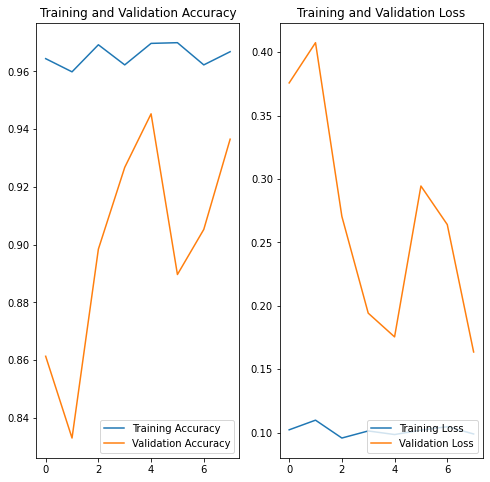

In [75]:
acc = ensemble_history.history['accuracy']
val_acc = ensemble_history.history['val_accuracy']

loss = ensemble_history.history['loss']
val_loss = ensemble_history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize =(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
# ensemble_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Pneumonia/models/ensemble_model.h5')

In [77]:
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            2299137     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            21868513    input_3[0][0]                    
__________________________________________________________________________________________________
average_2 (Average)             (None, 1)            0           sequential_3[2][0]               
                                                                 sequential_2[1][0]         

In [78]:
y_pred = prediction.reshape(-1)
# y_pred

In [79]:
test_labels = [(tf.strings.split(i, '/')[-2].numpy().decode('utf-8')) for i in test_images]

In [80]:
labels = []
for i in test_labels:
  # print(i)
  if i == 'NORMAL':
    labels.append(0)
  elif i == 'PNEUMONIA':
    labels.append(1)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.80       177
         1.0       0.97      0.85      0.90       447

    accuracy                           0.87       624
   macro avg       0.84      0.89      0.85       624
weighted avg       0.89      0.87      0.87       624



In [50]:
print(confusion_matrix(y_pred, labels))

[[218  58]
 [ 16 332]]
